In [78]:
import math
import collections
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import hanziconv
import keras
import keras.preprocessing.sequence
import keras.preprocessing.text
import keras.backend as K

### requires a dataset: http://paraphrasing.org/~fujita/resources/NICT-QEAPE.html

In [81]:
matplotlib.rc('font', family='Droid Sans Fallback')

In [2]:
df_zh = pd.read_csv(
    './NICT-QEAPE-0.201710/zh/travel.ref',
    delimiter='\t',
    index_col=0,
    header=None)
df_zh[2] = df_zh[2].apply(lambda x: hanziconv.HanziConv.toTraditional(x))
df_zh.head()

,1,2
0,,
vp.a:11,1,到100ml為止。
vp.c:1757,1,10美元。
vp.f:295,1,每買10個便宜200日元。
vp.f:398,1,10點有空。
vp.j:13,1,超過10點的話，需要延長費用。


In [3]:
df_ja = pd.read_csv(
    './NICT-QEAPE-0.201710/ja/travel.source',
    delimiter='\t',
    index_col=0,
    header=None)
df_ja.head()

,1
0,
vp.a:11,100mlまでです。
vp.c:1757,10ドルになります
vp.f:295,10個買うごとに200円引きです
vp.f:398,10時から空いてます
vp.j:13,10時を過ぎると延長料金がかかります。


In [4]:
df_ja_zh = df_ja.join(df_zh, how='inner', lsuffix='_ja', rsuffix='_zh')
df_ja_zh.head()

,1_ja,1_zh,2
0,,,
vp.a:11,100mlまでです。,1,到100ml為止。
vp.c:1757,10ドルになります,1,10美元。
vp.f:295,10個買うごとに200円引きです,1,每買10個便宜200日元。
vp.f:398,10時から空いてます,1,10點有空。
vp.j:13,10時を過ぎると延長料金がかかります。,1,超過10點的話，需要延長費用。


In [5]:
df_data = df_ja_zh[['1_ja', 2]]
df_data = df_data.rename({0:'key', '1_ja':'ja', 2:'zh'}, axis=1)
df_data = df_data.copy()
del df_zh
del df_ja
df_data.head()

,ja,zh
0,,
vp.a:11,100mlまでです。,到100ml為止。
vp.c:1757,10ドルになります,10美元。
vp.f:295,10個買うごとに200円引きです,每買10個便宜200日元。
vp.f:398,10時から空いてます,10點有空。
vp.j:13,10時を過ぎると延長料金がかかります。,超過10點的話，需要延長費用。


In [6]:
ja_tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
ja_tokenizer.fit_on_texts(df_data.ja)
df_data['ja_onehot'] = ja_tokenizer.texts_to_sequences(df_data.ja)
df_data.head()

,ja,zh,ja_onehot
0,,,
vp.a:11,100mlまでです。,到100ml為止。,"[177, 222, 222, 1280, 1281, 5, 4, 4, 3, 1]"
vp.c:1757,10ドルになります,10美元。,"[177, 222, 83, 52, 12, 13, 19, 5, 3]"
vp.f:295,10個買うごとに200円引きです,每買10個便宜200日元。,"[177, 222, 574, 104, 23, 66, 25, 12, 205, 222,..."
vp.f:398,10時から空いてます,10點有空。,"[177, 222, 54, 6, 31, 145, 2, 11, 5, 3]"
vp.j:13,10時を過ぎると延長料金がかかります。,超過10點的話，需要延長費用。,"[177, 222, 54, 14, 281, 199, 29, 25, 1282, 299..."


In [7]:
zh_tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
zh_tokenizer.fit_on_texts(df_data.zh)
df_data['zh_onehot'] = zh_tokenizer.texts_to_sequences(df_data.zh)
df_data.head()

,ja,zh,ja_onehot,zh_onehot
0,,,,
vp.a:11,100mlまでです。,到100ml為止。,"[177, 222, 222, 1280, 1281, 5, 4, 4, 3, 1]","[27, 125, 133, 133, 533, 705, 55, 359, 1]"
vp.c:1757,10ドルになります,10美元。,"[177, 222, 83, 52, 12, 13, 19, 5, 3]","[125, 133, 144, 259, 1]"
vp.f:295,10個買うごとに200円引きです,每買10個便宜200日元。,"[177, 222, 574, 104, 23, 66, 25, 12, 205, 222,...","[334, 105, 125, 133, 20, 242, 482, 169, 133, 1..."
vp.f:398,10時から空いてます,10點有空。,"[177, 222, 54, 6, 31, 145, 2, 11, 5, 3]","[125, 133, 30, 11, 217, 1]"
vp.j:13,10時を過ぎると延長料金がかかります。,超過10點的話，需要延長費用。,"[177, 222, 54, 14, 281, 199, 29, 25, 1282, 299...","[786, 66, 125, 133, 30, 3, 70, 18, 186, 22, 12..."


In [59]:
K.clear_session()
X_input = keras.layers.Input((None,), dtype='int32')
X_prev = keras.layers.Input((32,), dtype='int32')
X_prev_reduced = keras.layers.Embedding(len(zh_tokenizer.word_index)+1, 64)(X_prev)
X_encoder = keras.layers.Embedding(len(ja_tokenizer.word_index)+1, 64)(X_input)
X_encoder = keras.layers.Conv1D(64, 3, padding='same', activation='relu')(X_encoder)
X_encoder, X_encoder_hf, X_encoder_cf, X_encoder_hb, X_encoder_cb = keras.layers.Bidirectional(
    keras.layers.LSTM(64, return_sequences=True, return_state=True), merge_mode='sum')(X_encoder)
X_state = (X_encoder_hf + X_encoder_hb, X_encoder_cf + X_encoder_cb)
X_atts = []
X_outputs = []
X_att2 = keras.layers.TimeDistributed(keras.layers.Dense(64, activation='relu'))
X_att3 = keras.layers.TimeDistributed(keras.layers.Dense(1))
X_att4 = keras.layers.Softmax(-2)
X_decoder1 = keras.layers.Dot(-2)
X_decoder2 = keras.layers.Permute([2, 1])
X_decoder3 = keras.layers.Concatenate()
X_decoder4 = keras.layers.LSTM(64, return_state=True)
X_decoder5 = keras.layers.Dense(len(zh_tokenizer.word_index)+1, activation='softmax')
for i in range(32):
    X_att = keras.layers.Lambda(lambda x: K.concatenate([x, K.tile(K.reshape(X_state[0], [K.shape(X_state[0])[0],1,64]),[1,K.shape(x)[1],1])]))(X_encoder)
    X_att = X_att2(X_att)
    X_att = X_att3(X_att)
    X_att = X_att4(X_att)
    X_atts.append(X_att)
    X_decoder = X_decoder1([X_encoder, X_att])
    X_decoder = X_decoder2(X_decoder)
    X_decoder = X_decoder3([X_decoder, keras.layers.Lambda(lambda x: x[:,i:i+1,:])(X_prev_reduced)])
    X_decoder, X_decoder_h, X_decoder_c = X_decoder4(X_decoder, initial_state=X_state)
    X_state = (X_decoder_h, X_decoder_c)
    X_decoder = X_decoder5(X_decoder)
    X_outputs.append(X_decoder)
X_atts = keras.layers.Lambda(lambda x: K.squeeze(K.stack(x, axis=-2), axis=-1))(X_atts)
M_att = keras.models.Model([X_input, X_prev], [X_atts])
M_att.compile('adam', 'mse')
#M_att.summary()
X_outputs = keras.layers.Lambda(lambda x: K.stack(x, axis=-2))(X_outputs)
M_train = keras.models.Model([X_input, X_prev], [X_outputs])
M_train.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
#M_train.summary()

In [56]:
def data_gen():
    while True:
        df = df_data.sample(frac=1.)
        for i in range(math.ceil(len(df_data)/32)):
            ja_padded = keras.preprocessing.sequence.pad_sequences(df.ja_onehot[i*32:(i+1)*32], maxlen=32, padding='post', truncating='post')
            ja_vec = np.array(ja_padded, dtype=np.int32)
            zh_padded = keras.preprocessing.sequence.pad_sequences(df.zh_onehot[i*32:(i+1)*32], maxlen=32, padding='post', truncating='post')
            zh_vec = np.array([keras.utils.to_categorical(zh_p, num_classes=len(zh_tokenizer.word_index)+1) for zh_p in zh_padded])
            zh_sht_vec = np.concatenate([np.zeros((zh_padded.shape[0],1), dtype=np.int32), zh_padded[:,:-1]], axis=-1)
            yield [[ja_vec, zh_sht_vec], [zh_vec]]

In [100]:
M_train.fit_generator(data_gen(), steps_per_epoch=math.ceil(len(df_data)/32), epochs=30)

Epoch 1/30
275/275 [==============================] - 60s 219ms/step - loss: 0.2897 - acc: 0.9367
Epoch 2/30
275/275 [==============================] - 60s 218ms/step - loss: 0.2819 - acc: 0.9386
Epoch 3/30
275/275 [==============================] - 60s 217ms/step - loss: 0.2779 - acc: 0.9395
Epoch 4/30
275/275 [==============================] - 59s 216ms/step - loss: 0.2748 - acc: 0.9398
Epoch 5/30
275/275 [==============================] - 60s 217ms/step - loss: 0.2707 - acc: 0.9410
Epoch 6/30
275/275 [==============================] - 59s 216ms/step - loss: 0.2685 - acc: 0.9411
Epoch 7/30
275/275 [==============================] - 60s 217ms/step - loss: 0.2591 - acc: 0.9439
Epoch 8/30
275/275 [==============================] - 60s 218ms/step - loss: 0.2532 - acc: 0.9451
Epoch 9/30
275/275 [==============================] - 60s 217ms/step - loss: 0.2500 - acc: 0.9457
Epoch 10/30
275/275 [==============================] - 60s 217ms/step - loss: 0.2481 - acc: 0.9456
Epoch 11/30
275/275

In [10]:
zh_lookup = {v:k for k,v in zh_tokenizer.word_index.items()}

ja                                           クレジットカードじゃないとできない
zh                                                 不是信用卡的話，不行。
ja_onehot    [73, 74, 122, 59, 49, 78, 26, 83, 116, 103, 13...
zh_onehot          [10, 5, 173, 54, 328, 3, 70, 18, 10, 67, 1]
Name: vp.a:949, dtype: object
translated: 不是成存款不要演。


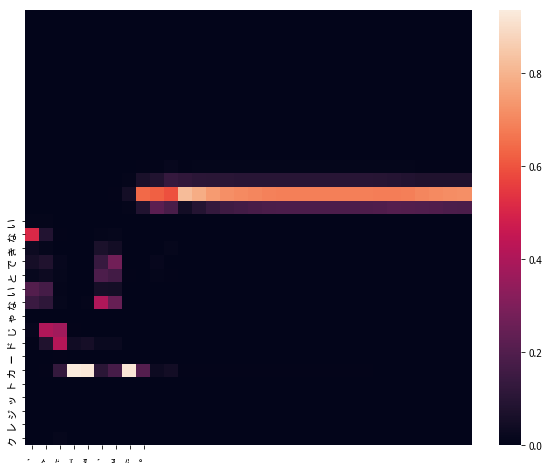

In [130]:
test_idx = 2709
print(df_data.iloc[test_idx])
test_vec = np.array(keras.preprocessing.sequence.pad_sequences(df_data.ja_onehot[test_idx:test_idx+1], maxlen=32, padding='post', truncating='post'), dtype=np.int32)
test_pred = []
for i in range(32):
    test_prev = np.concatenate([
        np.zeros((1,1), dtype=np.int32),
        np.array([test_pred[:i]], dtype=np.int32),
        np.zeros((1,(32-i-1)), dtype=np.int32)
    ], axis=1)
    test_pred = np.argmax(M_train.predict([test_vec, test_prev])[0], axis=-1)
translated = ''.join([zh_lookup.get(onehot, '') for onehot in test_pred])
print('translated:', translated)
attention = M_att.predict([test_vec, test_prev])[0]
plt.figure(figsize=(10,8))
ax = sns.heatmap(attention, xticklabels=translated, yticklabels=df_data.ja[test_idx])
ax.invert_yaxis()
plt.show()

In [40]:
test_idx = 700
print(df_data.iloc[test_idx])
test_vec = np.array([keras.utils.to_categorical(keras.preprocessing.sequence.pad_sequences(df_data.ja_onehot[test_idx:test_idx+1], maxlen=32, padding='post', truncating='post')[0], num_classes=len(ja_tokenizer.word_index)+1)])
M_att.predict(test_vec)[0]

ja                                   お仕事大変ですね
zh                                     工作辛苦吧。
ja_onehot    [34, 179, 81, 63, 196, 4, 3, 50]
zh_onehot         [118, 110, 513, 487, 36, 1]
Name: vp.a:675, dtype: object


array([[[2.00314447e-04],
        [2.00313865e-04],
        [2.00313327e-04],
        [1.73081149e-04],
        [1.73081440e-04],
        [1.73080814e-04],
        [1.73081280e-04],
        [1.73081586e-04],
        [1.73080261e-04],
        [1.73081542e-04],
        [1.73081629e-04],
        [1.73081382e-04],
        [1.73080902e-04],
        [2.44477094e-04],
        [2.68133823e-04],
        [3.01744643e-04],
        [3.44843080e-04],
        [3.44841887e-04],
        [3.44843284e-04],
        [3.44842789e-04],
        [3.44843051e-04],
        [3.44842818e-04],
        [3.44841625e-04],
        [3.44842585e-04],
        [3.44843167e-04],
        [3.44841392e-04],
        [3.44842061e-04],
        [3.44841596e-04],
        [3.44843313e-04],
        [3.44842556e-04],
        [3.44841625e-04],
        [3.44844040e-04]],

       [[1.98381424e-01],
        [1.98381528e-01],
        [1.98380217e-01],
        [7.74830207e-02],
        [7.74831548e-02],
        [7.74831697e-02],
        [7